In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import warnings
import math

import pandas as pd
import numpy as np

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, interact_manual
from ipywidgets import FloatSlider

from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import DBSCAN

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

<IPython.core.display.Javascript object>

In [3]:
def print_vif(x, start, stop):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs[start:stop], index=x.columns[start:stop]))
    print("-------------------------------\n")

<IPython.core.display.Javascript object>

In [4]:
df = pd.read_csv("data/tracks.csv", index_col=0)
pitch_df = pd.read_csv("data/pitch_covariance.csv", index_col=0)
timbre_df = pd.read_csv("data/timbre_covariance.csv", index_col=0)

df["genres"] = df["genres"].fillna("not listed")

<IPython.core.display.Javascript object>

In [5]:
X = timbre_df.drop("id", 1)

<IPython.core.display.Javascript object>

In [111]:
timbre_df.head()

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t10-t9,t11-t9,t0-t10,t1-t10,t10-t10,t0-t11,t1-t11,t10-t11,t11-t11,id
0,46.858569,44.411633,-30.611277,16.679608,24.081611,19.701484,-11.396656,2.506514,-4.164536,7.458277,...,23.006361,94.763566,22.384988,25.194126,1033.044512,-11.459746,-13.901388,-130.183017,287.766839,4Oun2ylbjFKMPTiaSbbCih
1,47.159141,-4.288257,16.865750,1.418398,31.826047,-12.211672,8.417109,-1.868587,-14.938674,-6.903131,...,-14.494244,6.548969,-5.519381,-66.234447,487.482081,-4.341169,-104.505943,-63.314290,209.365441,2SAqBLGA283SUiwJ3xOUVI
2,49.515635,16.938579,-20.712831,-17.707178,26.324125,-15.340620,-0.283205,6.923570,-9.580792,-2.385083,...,17.080190,28.006680,14.855904,80.285308,595.003409,-9.714251,2.217014,-99.822412,181.863172,3H7ihDc1dqLriiWXwsc2po
3,52.502006,40.068994,0.873336,-11.979764,41.415433,-32.069600,0.215288,-0.099545,-12.413600,1.999788,...,52.498463,3.833241,-2.064249,-20.525046,309.388360,-9.336740,75.105173,-19.921382,143.134342,6UelLqGlWMcVH1E5c4H7lY
4,47.822759,19.388920,-13.728099,-0.509172,31.229071,-11.967344,-5.113186,-2.071599,-15.770531,2.152821,...,16.023638,44.897820,-11.715826,-96.440490,487.376608,-23.759403,-31.718711,-24.650577,281.271995,7ytR5pFWmSjzHJIeQkgog4


<IPython.core.display.Javascript object>

In [6]:
scaler = StandardScaler()
std_X = scaler.fit_transform(X)

<IPython.core.display.Javascript object>

In [7]:
# putting together hover information for plotly data later

desc_cols = [
    "artist",
    "title",
    "popularity",
    "danceability",
    "energy",
    "loudness",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "genres",
]

px_num = df[desc_cols].select_dtypes("number")
px_cat = df[desc_cols].select_dtypes("O")

minmax_scaler = MinMaxScaler()
scaled_num = pd.DataFrame(minmax_scaler.fit_transform(px_num), columns=px_num.columns)
px_df = pd.concat([scaled_num, px_cat], 1)
px_df = px_df.round(1)

<IPython.core.display.Javascript object>

In [8]:
# first set of decent params
#     n_neighbors=6,
#     min_dist=0.1,
#     metric="cosine",
# dbscan
# eps=0.2, min_samples=40

# tighter clusters
#n_neighbors=12, min_dist=0.001 
#eps=0.2, min_samples=40
# clusters even tighter
#eps=0.17, min_samples=45
# pretty good at clustering out the more 'exotic' soounding stuff
#eps=0.13, min_samples=30



<IPython.core.display.Javascript object>

In [9]:
umap = UMAP(
    n_components=2, n_neighbors=30, min_dist=0.001, metric="cosine", random_state=42,
)
umap_df = pd.DataFrame(umap.fit_transform(std_X), columns=["c0", "c1"])

<IPython.core.display.Javascript object>

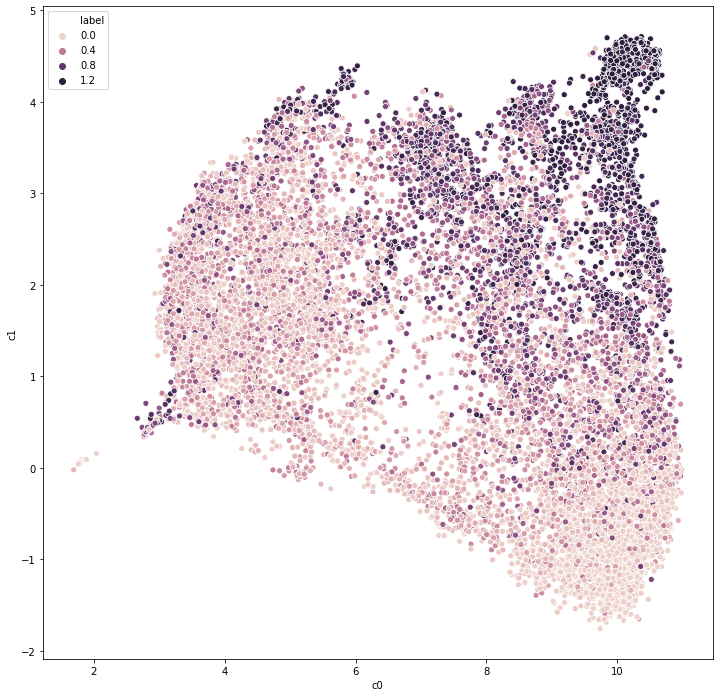

<IPython.core.display.Javascript object>

In [10]:
umap_df["label"] = df["acousticness"]
plt.figure(figsize=(12, 12))
sns.scatterplot("c0", "c1", hue="label", data=umap_df)

In [11]:
px_df["x1"] = umap_df["c0"]
px_df["x2"] = umap_df["c1"]

<IPython.core.display.Javascript object>

In [12]:
X = umap_df[["c0", "c1"]]

clst = DBSCAN(eps=0.13, min_samples=30)
clst.fit(X)

DBSCAN(algorithm='auto', eps=0.13, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=30, n_jobs=None, p=None)

<IPython.core.display.Javascript object>

In [13]:
px_df["clst_label"] = clst.labels_
px_df["clst_label"].value_counts()

-1     4249
 3     2955
 0     1877
 1      542
 4      413
 6      366
 5      331
 14     304
 12     243
 16     233
 25     215
 13     205
 2      140
 9      126
 19     109
 23     104
 10      69
 11      65
 7       65
 17      63
 21      57
 22      57
 24      53
 18      50
 15      47
 20      46
 8       42
 27      30
 26      15
Name: clst_label, dtype: int64

<IPython.core.display.Javascript object>

In [14]:
px_df["clst_label"].nunique()

29

<IPython.core.display.Javascript object>

In [15]:
# Remove DBSCAN's outlier cluster
plot_df = px_df[px_df["clst_label"] != -1].copy()

# Make cluster label a string so plotly colors like categorical rather than continuous
plot_df["clst_label"] = "'" + plot_df["clst_label"].astype(str) + "'"

<IPython.core.display.Javascript object>

In [16]:
x_range = [math.floor(plot_df["x1"].min()), math.ceil(plot_df["x1"].max())]
y_range = [math.floor(plot_df["x2"].min()), math.ceil(plot_df["x2"].max())]

descriptors = px_num.columns

<IPython.core.display.Javascript object>

In [ ]:


@interact(
    filter_col = descriptors,
    min_val=FloatSlider(min=0.0,max=1.0, step=0.01,value=0,continuous_update=False),
    max_val=FloatSlider(min=0.0,max=1.0, step=0.01,value=1,continuous_update=False),
    
)
def song_plot(filter_col, min_val=0.0, max_val=1.0):
    int_plot_df = plot_df.copy()
    int_plot_df = int_plot_df[int_plot_df[filter_col].between(min_val, max_val)]
    fig = px.scatter(
        data_frame=int_plot_df,
        x="x1",
        y="x2",
        color="clst_label",
        hover_data=desc_cols+['clst_label'],
        range_x = x_range,
        range_y=y_range
    )

#     fig.update_layout(showlegend=False)
    fig.show()


In [ ]:
@interact_manual(
    search_genre=False,
    genre='search'
)
def song_plot( genre,search_genre):
    
    int_plot_df = plot_df.copy()
    if search_genre==True:
        int_plot_df = int_plot_df[int_plot_df["genres"].str.contains(genre)]
    fig = px.scatter(
        data_frame=int_plot_df,
        x="x1",
        y="x2",
        color="clst_label",
        hover_data=desc_cols+['clst_label'],
        range_x = x_range,
        range_y=y_range
    )

#     fig.update_layout(showlegend=False)
    fig.show()


In [19]:
art_df = pd.read_csv("data/artist_info.csv", index_col=0)

<IPython.core.display.Javascript object>

In [20]:
def get_keyword_counts(data):
    micro_genre_count = {}
    word_count = {}
    for x in data["genres"]:
        m_genres = x.split(", ")
        for m in m_genres:
            if m not in micro_genre_count:
                micro_genre_count[m] = 1
            else:
                micro_genre_count[m] += 1
            words = m.split(" ")
            for word in words:
                if word not in word_count:
                    word_count[word] = 1
                else:
                    word_count[word] += 1
    try:
        del micro_genre_count[""]
        del word_count[""]
    except:
        pass
    return micro_genre_count, word_count

<IPython.core.display.Javascript object>

In [21]:
micro_genre_count, word_count = get_keyword_counts(df)

<IPython.core.display.Javascript object>

In [22]:
m_genre_series = pd.Series(micro_genre_count)
word_count_series = pd.Series(word_count)

<IPython.core.display.Javascript object>

In [23]:
whole_df_m_genre_rep = m_genre_series / df.shape[0]
whole_df_w_count_rep = word_count_series / df.shape[0]

<IPython.core.display.Javascript object>

In [24]:
clust_genre_dict = {}
clust_word_dict = {}

for cl in px_df["clst_label"].unique():
    cluster_sub_df = px_df[px_df["clst_label"] == cl]
    micro_genre_count, word_count = get_keyword_counts(cluster_sub_df)

    m_genre_series = pd.Series(micro_genre_count)
    word_series = pd.Series(word_count)

    m_genre_rep = m_genre_series / cluster_sub_df.shape[0]
    w_count_rep = word_series / cluster_sub_df.shape[0]

    clust_genre_dict["cluster_" + str(cl)] = m_genre_rep
    clust_word_dict["cluster_" + str(cl)] = w_count_rep

<IPython.core.display.Javascript object>

In [25]:
cluster_genre_df = pd.DataFrame(clust_genre_dict)
cluster_keyword_df = pd.DataFrame(clust_word_dict)

<IPython.core.display.Javascript object>

In [26]:
for col in cluster_genre_df.columns:
    top_7_g = cluster_genre_df[col].sort_values(ascending=False)[0:7]
    top_7_comp = whole_df_m_genre_rep[top_7_g.index]
    print("Micro Genre Comparison")
    display(
        pd.DataFrame(
            [top_7_g, top_7_comp], index=[col, "df"]
        ).T.style.background_gradient(axis=1)
    )
    top_12_w = cluster_keyword_df[col].sort_values(ascending=False)[0:12]
    top_12_comp = whole_df_w_count_rep[top_12_w.index]
    print("Keyword Comparison")
    display(
        pd.DataFrame(
            [top_12_w, top_12_comp], index=[col, "df"]
        ).T.style.background_gradient(axis=1)
    )

Micro Genre Comparison


,cluster_0,df
rap,0.210975,0.045903
pop,0.178476,0.104659
pop rap,0.163559,0.043531
hip hop,0.134790,0.034121
trap,0.130527,0.024176
dance pop,0.122003,0.076658
melodic rap,0.092168,0.016755


Keyword Comparison


,cluster_0,df
pop,0.995738,0.748068
rap,0.812999,0.195088
hip,0.775706,0.191646
hop,0.737880,0.177645
trap,0.295685,0.061816
r&b,0.269046,0.089205
dance,0.136921,0.120802
indie,0.124134,0.181317
reggae,0.114012,0.055160
dancehall,0.109217,0.032438


Micro Genre Comparison


,cluster_1,df
latin,0.265683,0.032974
reggaeton,0.238007,0.016296
pop,0.171587,0.104659
dance pop,0.154982,0.076658
tropical,0.145756,0.018208
latin pop,0.118081,0.022263
reggaeton flow,0.107011,0.006120


Keyword Comparison


,cluster_1,df
pop,1.256458,0.748068
latin,0.531365,0.112922
reggaeton,0.453875,0.030755
hip,0.269373,0.191646
hop,0.260148,0.177645
tropical,0.190037,0.043761
dance,0.186347,0.120802
rap,0.180812,0.195088
reggae,0.166052,0.055160
trap,0.166052,0.061816


Micro Genre Comparison


,cluster_-1,df
pop,0.125677,0.104659
dance pop,0.092022,0.076658
not listed,0.072017,0.075128
rock,0.061897,0.075281
soul,0.053424,0.036340
funk,0.051542,0.034504
post-teen pop,0.042128,0.036570


Keyword Comparison


,cluster_-1,df
pop,0.806778,0.748068
rock,0.530478,0.592304
indie,0.196281,0.181317
soul,0.177454,0.131283
jazz,0.170393,0.154005
hip,0.136973,0.191646
dance,0.135326,0.120802
country,0.126853,0.117359
folk,0.125677,0.098921
house,0.125441,0.085839


Micro Genre Comparison


,cluster_6,df
modern bollywood,0.207650,0.026394
filmi,0.196721,0.022875
desi pop,0.193989,0.031138
sufi,0.188525,0.017290
classic bollywood,0.112022,0.005508
dance pop,0.090164,0.076658
not listed,0.081967,0.075128


Keyword Comparison


,cluster_6,df
pop,0.827869,0.748068
rock,0.497268,0.592304
bollywood,0.319672,0.031903
modern,0.248634,0.119654
soul,0.248634,0.131283
classic,0.248634,0.071303
desi,0.196721,0.036952
filmi,0.196721,0.022875
country,0.193989,0.117359
sufi,0.188525,0.017290


Micro Genre Comparison


,cluster_2,df
soundtrack,0.221429,0.016449
not listed,0.171429,0.075128
video game music,0.135714,0.009410
scorecore,0.128571,0.010405
compositional ambient,0.114286,0.009257
background music,0.114286,0.004743
chill out,0.100000,0.006579


Keyword Comparison


,cluster_2,df
soundtrack,0.364286,0.026930
music,0.264286,0.026012
rock,0.228571,0.592304
ambient,0.185714,0.013235
listed,0.171429,0.075128
classical,0.171429,0.100604
not,0.171429,0.075128
game,0.135714,0.010252
video,0.135714,0.009410
scorecore,0.128571,0.010405


Micro Genre Comparison


,cluster_4,df
pop,0.191283,0.104659
indie folk,0.179177,0.030220
new americana,0.101695,0.016755
stomp and holler,0.087167,0.021115
not listed,0.079903,0.075128
neo mellow,0.077482,0.020656
dance pop,0.072639,0.076658


Keyword Comparison


,cluster_4,df
pop,1.096852,0.748068
indie,0.598063,0.181317
rock,0.481840,0.592304
folk,0.355932,0.098921
alternative,0.188862,0.138704
americana,0.167070,0.030679
r&b,0.167070,0.089205
singer-songwriter,0.154964,0.024711
hop,0.147700,0.177645
new,0.145278,0.095402


Micro Genre Comparison


,cluster_3,df
rock,0.202707,0.075281
alternative rock,0.094078,0.032438
pop rock,0.086294,0.040395
alternative metal,0.082910,0.024252
modern rock,0.077496,0.035422
permanent wave,0.069036,0.026088
dance rock,0.068697,0.024252


Keyword Comparison


,cluster_3,df
rock,1.398985,0.592304
pop,0.664975,0.748068
metal,0.397293,0.107796
alternative,0.286294,0.138704
punk,0.277157,0.082779
indie,0.212521,0.181317
country,0.206091,0.117359
new,0.163790,0.095402
wave,0.161083,0.060898
modern,0.153299,0.119654


Micro Genre Comparison


,cluster_15,df
afropop,0.234043,0.012776
nigerian pop,0.234043,0.011705
reggae,0.148936,0.011093
afro dancehall,0.148936,0.007268
dancehall,0.106383,0.019279
pop,0.106383,0.104659
rock steady,0.106383,0.004820


Keyword Comparison


,cluster_15,df
pop,0.617021,0.748068
dancehall,0.340426,0.032438
nigerian,0.319149,0.017061
reggae,0.255319,0.055160
rock,0.255319,0.592304
soul,0.234043,0.131283
afropop,0.234043,0.012776
hip,0.170213,0.191646
afro,0.148936,0.014383
hop,0.148936,0.177645


Micro Genre Comparison


,cluster_10,df
arab pop,0.246377,0.007191
not listed,0.144928,0.075128
shaabi,0.144928,0.004820
dabke,0.130435,0.003596
pop,0.115942,0.104659
dance pop,0.086957,0.076658
jordanian pop,0.086957,0.001836


Keyword Comparison


,cluster_10,df
pop,1.347826,0.748068
arab,0.289855,0.016602
listed,0.144928,0.075128
new,0.144928,0.095402
not,0.144928,0.075128
dance,0.144928,0.120802
shaabi,0.144928,0.004820
rock,0.130435,0.592304
dabke,0.130435,0.003596
r&b,0.101449,0.089205


Micro Genre Comparison


,cluster_13,df
indie folk,0.258537,0.030220
stomp and holler,0.160976,0.021115
new americana,0.146341,0.016755
rock,0.136585,0.075281
modern rock,0.136585,0.035422
indie rock,0.131707,0.022263
indie pop,0.107317,0.023564


Keyword Comparison


,cluster_13,df
rock,1.058537,0.592304
pop,0.780488,0.748068
indie,0.775610,0.181317
folk,0.502439,0.098921
country,0.341463,0.117359
new,0.253659,0.095402
alternative,0.243902,0.138704
americana,0.243902,0.030679
modern,0.209756,0.119654
stomp,0.180488,0.022340


Micro Genre Comparison


,cluster_5,df
not listed,0.274924,0.075128
chill out,0.099698,0.006579
pop,0.087613,0.104659
dance pop,0.057402,0.076658
tropical house,0.045317,0.024329
edm,0.036254,0.021880
afropop,0.036254,0.012776


Keyword Comparison


,cluster_5,df
pop,0.389728,0.748068
house,0.299094,0.085839
listed,0.274924,0.075128
not,0.274924,0.075128
chill,0.129909,0.012623
indie,0.126888,0.181317
r&b,0.117825,0.089205
rock,0.105740,0.592304
out,0.099698,0.006579
rap,0.093656,0.195088


Micro Genre Comparison


,cluster_11,df
dance pop,0.184615,0.076658
pop,0.184615,0.104659
tropical house,0.138462,0.024329
edm,0.138462,0.021880
electro house,0.107692,0.014306
latin,0.092308,0.032974
post-teen pop,0.092308,0.036570


Keyword Comparison


,cluster_11,df
pop,1.092308,0.748068
house,0.553846,0.085839
rock,0.323077,0.592304
dance,0.246154,0.120802
latin,0.246154,0.112922
tropical,0.230769,0.043761
indie,0.200000,0.181317
edm,0.200000,0.034427
electro,0.184615,0.023181
jazz,0.169231,0.154005


Micro Genre Comparison


,cluster_27,df
dance pop,0.233333,0.076658
pop,0.233333,0.104659
k-pop,0.200000,0.019432
desi pop,0.200000,0.031138
house,0.166667,0.005967
tropical house,0.166667,0.024329
modern bollywood,0.133333,0.026394


Keyword Comparison


,cluster_27,df
pop,1.100000,0.748068
house,0.500000,0.085839
dance,0.400000,0.120802
desi,0.300000,0.036952
k-pop,0.300000,0.029990
jazz,0.233333,0.154005
uk,0.200000,0.042231
r&b,0.166667,0.089205
tropical,0.166667,0.043761
soul,0.166667,0.131283


Micro Genre Comparison


,cluster_14,df
classical,0.440789,0.026318
classical performance,0.309211,0.015378
soundtrack,0.171053,0.016449
orchestral performance,0.141447,0.005585
classical era,0.131579,0.006656
orchestra,0.121711,0.006426
post-romantic era,0.108553,0.005202


Keyword Comparison


,cluster_14,df
classical,1.411184,0.100604
performance,0.486842,0.023564
orchestra,0.378289,0.018438
era,0.361842,0.019585
soundtrack,0.282895,0.026930
piano,0.161184,0.042154
early,0.157895,0.014383
german,0.151316,0.020274
music,0.148026,0.026012
modern,0.144737,0.119654


Micro Genre Comparison


,cluster_8,df
country,0.119048,0.018973
soul,0.095238,0.036340
country rock,0.095238,0.014919
piano rock,0.095238,0.003749
rock,0.095238,0.075281
new wave pop,0.095238,0.016143
brill building pop,0.095238,0.012011


Keyword Comparison


,cluster_8,df
rock,0.880952,0.592304
pop,0.857143,0.748068
country,0.404762,0.117359
soul,0.285714,0.131283
wave,0.190476,0.060898
metal,0.166667,0.107796
classic,0.166667,0.071303
new,0.119048,0.095402
christian,0.119048,0.016678
alternative,0.119048,0.138704


Micro Genre Comparison


,cluster_17,df
pop,0.111111,0.104659
dance pop,0.095238,0.076658
rock-and-roll,0.095238,0.009640
country,0.095238,0.018973
rockabilly,0.095238,0.007651
folk rock,0.079365,0.022569
urban contemporary,0.063492,0.033433


Keyword Comparison


,cluster_17,df
pop,0.825397,0.748068
rock,0.666667,0.592304
country,0.285714,0.117359
latin,0.206349,0.112922
hip,0.174603,0.191646
rap,0.158730,0.195088
hop,0.158730,0.177645
folk,0.142857,0.098921
metal,0.142857,0.107796
dance,0.142857,0.120802


Micro Genre Comparison


,cluster_12,df
funk,0.242798,0.034504
soul,0.185185,0.036340
motown,0.156379,0.027618
quiet storm,0.152263,0.027848
urban contemporary,0.106996,0.033433
dance pop,0.102881,0.076658
disco,0.098765,0.014842


Keyword Comparison


,cluster_12,df
rock,0.703704,0.592304
pop,0.584362,0.748068
funk,0.489712,0.075740
soul,0.403292,0.131283
jazz,0.209877,0.154005
new,0.193416,0.095402
house,0.176955,0.085839
dance,0.172840,0.120802
motown,0.156379,0.028154
african,0.152263,0.013312


Micro Genre Comparison


,cluster_7,df
pop,0.215385,0.104659
indie folk,0.153846,0.030220
new americana,0.123077,0.016755
folk,0.123077,0.014153
stomp and holler,0.107692,0.021115
folk rock,0.076923,0.022569
lilith,0.076923,0.005432


Keyword Comparison


,cluster_7,df
pop,0.938462,0.748068
rock,0.723077,0.592304
folk,0.523077,0.098921
indie,0.446154,0.181317
country,0.338462,0.117359
soul,0.261538,0.131283
new,0.215385,0.095402
americana,0.200000,0.030679
and,0.123077,0.024252
stomp,0.123077,0.022340


Micro Genre Comparison


,cluster_9,df
tropical,0.277778,0.018208
salsa,0.253968,0.004590
latin,0.222222,0.032974
latin jazz,0.134921,0.007268
modern salsa,0.126984,0.001913
salsa peruana,0.119048,0.001377
latin pop,0.087302,0.022263


Keyword Comparison


,cluster_9,df
salsa,0.746032,0.012088
pop,0.555556,0.748068
latin,0.500000,0.112922
jazz,0.396825,0.154005
tropical,0.277778,0.043761
rock,0.230159,0.592304
modern,0.222222,0.119654
soul,0.126984,0.131283
peruana,0.119048,0.001377
colombiana,0.111111,0.001530


Micro Genre Comparison


,cluster_26,df
pop,0.266667,0.104659
k-pop,0.133333,0.019432
latin pop,0.133333,0.022263
album rock,0.133333,0.022263
neo mellow,0.133333,0.020656
latin,0.133333,0.032974
hard rock,0.133333,0.015684


Keyword Comparison


,cluster_26,df
pop,1.266667,0.748068
rock,1.133333,0.592304
punk,0.333333,0.082779
latin,0.266667,0.112922
k-pop,0.266667,0.029990
hop,0.200000,0.177645
hip,0.200000,0.191646
neo,0.200000,0.039706
soul,0.200000,0.131283
dance,0.200000,0.120802


Micro Genre Comparison


,cluster_23,df
"""children's story""",0.336538,0.002831
nursery,0.182692,0.001683
not listed,0.153846,0.075128
"""children's music""",0.105769,0.004055
pop,0.048077,0.104659
neo soul,0.048077,0.017749
urban contemporary,0.048077,0.033433


Keyword Comparison


,cluster_23,df
"""children's",0.461538,0.008722
"story""",0.336538,0.002831
nursery,0.182692,0.001683
not,0.153846,0.075128
listed,0.153846,0.075128
pop,0.125000,0.748068
"music""",0.125000,0.005355
soul,0.115385,0.131283
neo,0.086538,0.039706
reading,0.048077,0.000536


Micro Genre Comparison


,cluster_25,df
contemporary post-bop,0.530233,0.014077
jazz,0.506977,0.014383
cool jazz,0.497674,0.014077
bebop,0.479070,0.013465
hard bop,0.409302,0.011170
soul jazz,0.353488,0.011017
jazz fusion,0.348837,0.010634


Keyword Comparison


,cluster_25,df
jazz,3.990698,0.154005
contemporary,0.790698,0.089817
post-bop,0.530233,0.014077
cool,0.497674,0.014077
bebop,0.479070,0.013465
hard,0.409302,0.027542
bop,0.409302,0.011170
fusion,0.395349,0.023487
soul,0.372093,0.131283
vocal,0.241860,0.010940


Micro Genre Comparison


,cluster_20,df
motown,0.195652,0.027618
brill building pop,0.173913,0.012011
soul,0.173913,0.036340
rock,0.152174,0.075281
folk rock,0.130435,0.022569
adult standards,0.130435,0.018132
country,0.108696,0.018973


Keyword Comparison


,cluster_20,df
rock,1.000000,0.592304
pop,0.913043,0.748068
country,0.434783,0.117359
soul,0.304348,0.131283
classic,0.282609,0.071303
blues,0.239130,0.034427
motown,0.195652,0.028154
metal,0.195652,0.107796
brill,0.173913,0.012011
building,0.173913,0.012011


Micro Genre Comparison


,cluster_18,df
desi pop,0.140000,0.031138
soul,0.140000,0.036340
motown,0.120000,0.027618
classic soul,0.120000,0.017520
rock-and-roll,0.100000,0.009640
brill building pop,0.100000,0.012011
filmi,0.100000,0.022875


Keyword Comparison


,cluster_18,df
pop,0.520000,0.748068
rock,0.360000,0.592304
soul,0.340000,0.131283
country,0.280000,0.117359
classic,0.240000,0.071303
bollywood,0.160000,0.031903
modern,0.140000,0.119654
desi,0.140000,0.036952
alternative,0.140000,0.138704
motown,0.120000,0.028154


Micro Genre Comparison


,cluster_16,df
classical,0.429185,0.026318
classical piano,0.330472,0.008951
classical performance,0.184549,0.015378
not listed,0.133047,0.075128
early music,0.111588,0.005126
baroque,0.107296,0.004514
german baroque,0.094421,0.003749


Keyword Comparison


,cluster_16,df
classical,1.858369,0.100604
piano,0.987124,0.042154
era,0.343348,0.019585
early,0.266094,0.014383
performance,0.240343,0.023564
baroque,0.214592,0.014766
jazz,0.197425,0.154005
german,0.193133,0.020274
romantic,0.163090,0.017749
listed,0.133047,0.075128


Micro Genre Comparison


,cluster_19,df
background piano,0.348624,0.003902
not listed,0.266055,0.075128
calming instrumental,0.137615,0.004896
piano cover,0.091743,0.001989
focus,0.082569,0.003596
neo-classical,0.082569,0.003443
compositional ambient,0.073394,0.009257


Keyword Comparison


,cluster_19,df
piano,0.550459,0.042154
background,0.394495,0.008645
listed,0.266055,0.075128
not,0.266055,0.075128
classical,0.201835,0.100604
instrumental,0.137615,0.011629
calming,0.137615,0.004896
cover,0.091743,0.002066
ambient,0.091743,0.013235
music,0.082569,0.026012


Micro Genre Comparison


,cluster_21,df
mahraganat,0.561404,0.004284
shaabi,0.350877,0.004820
egyptian pop,0.280702,0.003978
not listed,0.228070,0.075128
soul,0.052632,0.036340
hip hop,0.035088,0.034121
r&b,0.035088,0.031214


Keyword Comparison


,cluster_21,df
mahraganat,0.561404,0.004284
pop,0.438596,0.748068
shaabi,0.350877,0.004820
egyptian,0.280702,0.005279
listed,0.228070,0.075128
not,0.228070,0.075128
soul,0.175439,0.131283
hip,0.157895,0.191646
hop,0.122807,0.177645
rap,0.087719,0.195088


Micro Genre Comparison


,cluster_22,df
chill guitar,0.421053,0.001989
calming instrumental,0.403509,0.004896
not listed,0.245614,0.075128
focus,0.087719,0.003596
classify,0.052632,0.002525
background music,0.035088,0.004743
acoustic chill,0.035088,0.000153


Keyword Comparison


,cluster_22,df
chill,0.456140,0.012623
guitar,0.421053,0.004896
instrumental,0.421053,0.011629
calming,0.403509,0.004896
not,0.245614,0.075128
listed,0.245614,0.075128
rock,0.105263,0.592304
focus,0.087719,0.003902
country,0.087719,0.117359
post-rock,0.070175,0.004361


Micro Genre Comparison


,cluster_24,df
asmr,1.000000,0.004437
"""australian children's music""",nan,0.000306
"""black 'n' roll""",nan,0.000077
"""canadian children's music""",nan,0.000306
"""children's folk""",nan,0.001836
"""children's music""",nan,0.004055
"""children's story""",nan,0.002831


Keyword Comparison


,cluster_24,df
asmr,1.000000,0.004437
"""australian",nan,0.000306
"""black",nan,0.000077
"""canadian",nan,0.000306
"""children's",nan,0.008722
"""death",nan,0.000077
"""preschool",nan,0.000153
"""punk",nan,0.000459
"""women's",nan,0.000612
'n',nan,0.000612


<IPython.core.display.Javascript object>

In [27]:
X = timbre_df.drop("id", 1)

<IPython.core.display.Javascript object>

In [28]:
timbre_df.head()

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t10-t9,t11-t9,t0-t10,t1-t10,t10-t10,t0-t11,t1-t11,t10-t11,t11-t11,id
0,46.858569,44.411633,-30.611277,16.679608,24.081611,19.701484,-11.396656,2.506514,-4.164536,7.458277,...,23.006361,94.763566,22.384988,25.194126,1033.044512,-11.459746,-13.901388,-130.183017,287.766839,4Oun2ylbjFKMPTiaSbbCih
1,47.159141,-4.288257,16.865750,1.418398,31.826047,-12.211672,8.417109,-1.868587,-14.938674,-6.903131,...,-14.494244,6.548969,-5.519381,-66.234447,487.482081,-4.341169,-104.505943,-63.314290,209.365441,2SAqBLGA283SUiwJ3xOUVI
2,49.515635,16.938579,-20.712831,-17.707178,26.324125,-15.340620,-0.283205,6.923570,-9.580792,-2.385083,...,17.080190,28.006680,14.855904,80.285308,595.003409,-9.714251,2.217014,-99.822412,181.863172,3H7ihDc1dqLriiWXwsc2po
3,52.502006,40.068994,0.873336,-11.979764,41.415433,-32.069600,0.215288,-0.099545,-12.413600,1.999788,...,52.498463,3.833241,-2.064249,-20.525046,309.388360,-9.336740,75.105173,-19.921382,143.134342,6UelLqGlWMcVH1E5c4H7lY
4,47.822759,19.388920,-13.728099,-0.509172,31.229071,-11.967344,-5.113186,-2.071599,-15.770531,2.152821,...,16.023638,44.897820,-11.715826,-96.440490,487.376608,-23.759403,-31.718711,-24.650577,281.271995,7ytR5pFWmSjzHJIeQkgog4


<IPython.core.display.Javascript object>

In [29]:
drop_cols = ["t2-t2", "t3-t3", "t5-t5", "t7-t7", "t9-t9", "t10-t10"]
X = X.drop(drop_cols, 1)

<IPython.core.display.Javascript object>

In [110]:
timbre_df.head()

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t10-t9,t11-t9,t0-t10,t1-t10,t10-t10,t0-t11,t1-t11,t10-t11,t11-t11,id
0,46.858569,44.411633,-30.611277,16.679608,24.081611,19.701484,-11.396656,2.506514,-4.164536,7.458277,...,23.006361,94.763566,22.384988,25.194126,1033.044512,-11.459746,-13.901388,-130.183017,287.766839,4Oun2ylbjFKMPTiaSbbCih
1,47.159141,-4.288257,16.865750,1.418398,31.826047,-12.211672,8.417109,-1.868587,-14.938674,-6.903131,...,-14.494244,6.548969,-5.519381,-66.234447,487.482081,-4.341169,-104.505943,-63.314290,209.365441,2SAqBLGA283SUiwJ3xOUVI
2,49.515635,16.938579,-20.712831,-17.707178,26.324125,-15.340620,-0.283205,6.923570,-9.580792,-2.385083,...,17.080190,28.006680,14.855904,80.285308,595.003409,-9.714251,2.217014,-99.822412,181.863172,3H7ihDc1dqLriiWXwsc2po
3,52.502006,40.068994,0.873336,-11.979764,41.415433,-32.069600,0.215288,-0.099545,-12.413600,1.999788,...,52.498463,3.833241,-2.064249,-20.525046,309.388360,-9.336740,75.105173,-19.921382,143.134342,6UelLqGlWMcVH1E5c4H7lY
4,47.822759,19.388920,-13.728099,-0.509172,31.229071,-11.967344,-5.113186,-2.071599,-15.770531,2.152821,...,16.023638,44.897820,-11.715826,-96.440490,487.376608,-23.759403,-31.718711,-24.650577,281.271995,7ytR5pFWmSjzHJIeQkgog4


<IPython.core.display.Javascript object>

In [30]:
print_vif(X, 0, 50)

VIF results
-------------------------------
const     284.982907
t0          3.563863
t1          3.633435
t2          4.328140
t3          3.183310
t4          2.212411
t5          4.189719
t6          2.390760
t7          3.287691
t8          1.925005
t9          3.303695
t10         7.971397
t11         1.532254
t0-t0       4.024734
t0-t1       3.467208
t1-t1       4.581912
t0-t2       4.583559
t1-t2       3.567717
t10-t2      3.157758
t11-t2      2.495304
t0-t3       2.925804
t1-t3       2.864251
t2-t3       4.832505
t10-t3      4.356292
t11-t3      2.310197
t0-t4       2.418759
t1-t4       2.009615
t2-t4       3.583937
t3-t4       2.108835
t4-t4       2.908808
t10-t4      2.028171
t11-t4      2.471064
t0-t5       3.851484
t1-t5       2.449492
t2-t5       3.025058
t3-t5       4.206816
t4-t5       3.170920
t10-t5      2.181824
t11-t5      2.167265
t0-t6       2.097983
t1-t6       2.418183
t2-t6       4.019985
t3-t6       4.012374
t4-t6       2.291370
t5-t6       3.295512
t6-t6      

<IPython.core.display.Javascript object>

In [31]:
print_vif(X, 50, X.shape[0])

VIF results
-------------------------------
t2-t7      3.454285
t3-t7      5.006942
t4-t7      1.571675
t5-t7      2.959424
t6-t7      2.347474
t10-t7     3.102606
t11-t7     1.922284
t0-t8      2.317516
t1-t8      1.805672
t2-t8      3.042688
t3-t8      2.661521
t4-t8      2.180510
t5-t8      3.239149
t6-t8      2.374827
t7-t8      2.603272
t8-t8      3.027866
t10-t8     2.227822
t11-t8     2.203360
t0-t9      2.030787
t1-t9      1.604162
t2-t9      2.266922
t3-t9      3.432036
t4-t9      1.861762
t5-t9      6.342237
t6-t9      2.215765
t7-t9      4.762264
t8-t9      5.033319
t10-t9     2.182779
t11-t9     2.576439
t0-t10     3.215232
t1-t10     2.477862
t0-t11     1.858326
t1-t11     1.617983
t10-t11    4.276934
t11-t11    2.730150
dtype: float64
-------------------------------



<IPython.core.display.Javascript object>

In [32]:
scaler = StandardScaler()
std_X = scaler.fit_transform(X)

<IPython.core.display.Javascript object>

In [33]:
umap = UMAP(
    n_components=2, n_neighbors=40, min_dist=0.001, metric="cosine", random_state=42,
)
umap_df = pd.DataFrame(umap.fit_transform(std_X), columns=["c0", "c1"])

<IPython.core.display.Javascript object>

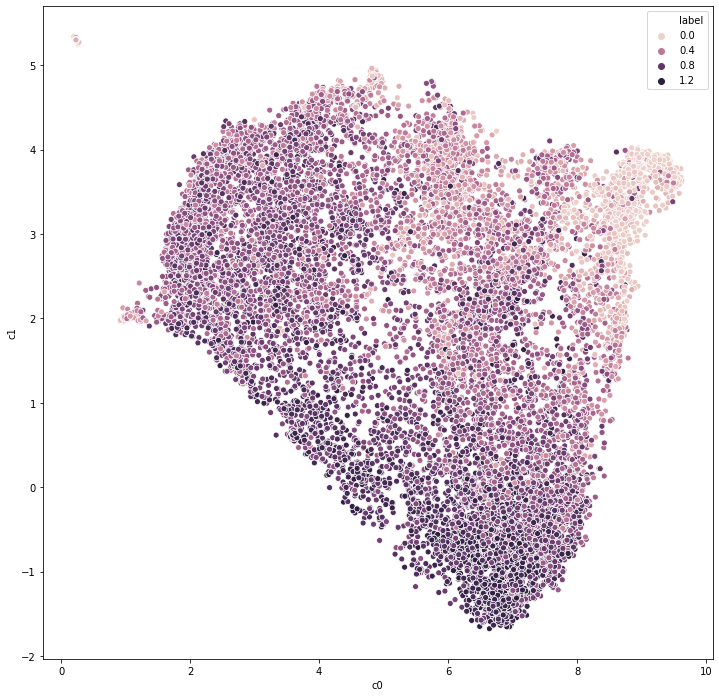

<IPython.core.display.Javascript object>

In [107]:
umap_df["label"] = df["energy"]
plt.figure(figsize=(12, 12))
sns.scatterplot("c0", "c1", hue="label", data=umap_df)

In [35]:
px_df["x1"] = umap_df["c0"]
px_df["x2"] = umap_df["c1"]

<IPython.core.display.Javascript object>

In [36]:
X = umap_df[["c0", "c1"]]

clst = DBSCAN(eps=0.127, min_samples=30)
clst.fit(X)

DBSCAN(algorithm='auto', eps=0.127, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=30, n_jobs=None, p=None)

<IPython.core.display.Javascript object>

In [37]:
px_df["clst_label"] = clst.labels_
px_df["clst_label"].value_counts()

-1     4742
 4     2577
 0     1774
 2      619
 3      535
 16     350
 19     296
 9      286
 6      268
 1      182
 22     150
 14     137
 13     134
 17     125
 12     107
 5       99
 7       84
 11      83
 8       81
 10      80
 20      56
 21      54
 18      54
 23      40
 15      37
 27      37
 25      30
 24      29
 26      25
Name: clst_label, dtype: int64

<IPython.core.display.Javascript object>

In [38]:
px_df["clst_label"].nunique()

29

<IPython.core.display.Javascript object>

In [39]:
# Remove DBSCAN's outlier cluster
plot_df = px_df[px_df["clst_label"] != -1].copy()

# Make cluster label a string so plotly colors like categorical rather than continuous
plot_df["clst_label"] = "'" + plot_df["clst_label"].astype(str) + "'"

<IPython.core.display.Javascript object>

In [40]:
x_range = [math.floor(plot_df["x1"].min()), math.ceil(plot_df["x1"].max())]
y_range = [math.floor(plot_df["x2"].min()), math.ceil(plot_df["x2"].max())]

descriptors = px_num.columns

<IPython.core.display.Javascript object>

In [183]:


@interact(
    filter_col = descriptors,
    min_val=FloatSlider(min=0.0,max=1.0, step=0.01,value=0,continuous_update=False),
    max_val=FloatSlider(min=0.0,max=1.0, step=0.01,value=1,continuous_update=False),
    
)
def song_plot(filter_col, min_val=0.0, max_val=1.0):
    int_plot_df = plot_df.copy()
    int_plot_df = int_plot_df[int_plot_df[filter_col].between(min_val, max_val)]
    fig = px.scatter(
        data_frame=int_plot_df,
        x="x1",
        y="x2",
        color='clst_label',
        hover_data=desc_cols+['clst_label'],
        range_x = x_range,
        range_y=y_range
    )

#     fig.update_layout(showlegend=False)
    fig.show()


interactive(children=(Dropdown(description='filter_col', options=('popularity', 'danceability', 'energy', 'lou…

<IPython.core.display.Javascript object>

In [61]:
plot_df["artist"].value_counts()[25:75]

Hamo Bika                   9
Burna Boy                   9
Popcaan                     9
Bryan Adams                 9
Songs For Children          9
Favorite Kids Stories       9
SAINt JHN                   9
The Cure                    9
Vybz Kartel                 9
DaBaby                      9
The Ultimate Storyteller    9
Oasis                       9
Franz Liszt                 8
Honor Blackman              8
Ed Sheeran                  8
Dua Lipa                    8
Zack Knight                 8
Post Malone                 8
The Temptations             8
Soda Stereo                 8
Stevie Wonder               8
Tory Lanez                  8
Red Hot Chili Peppers       8
Guns N' Roses               8
Beyoncé                     8
Nirvana                     7
Major Lazer                 7
EXO-SC                      7
Lil Mosey                   7
Sergei Rachmaninoff         7
Justin Bieber               7
DJ Khaled                   7
Alan Menken                 7
Elvis Pres

<IPython.core.display.Javascript object>

In [45]:
@interact_manual(
    search_artist=False, artist="search", search_genre=False, genre="search"
)
def song_plot(artist, search_artist, genre, search_genre):

    int_plot_df = plot_df.copy()
    if search_artist == True:
        int_plot_df = int_plot_df[int_plot_df["artist"].str.contains(artist)]

    if search_genre == True:
        int_plot_df = int_plot_df[int_plot_df["genres"].str.contains(genre)]
    fig = px.scatter(
        data_frame=int_plot_df,
        x="x1",
        y="x2",
        color="clst_label",
        hover_data=desc_cols,
        range_x=x_range,
        range_y=y_range,
    )

    #     fig.update_layout(showlegend=False)
    fig.show()

interactive(children=(Text(value='search', description='artist'), Checkbox(value=False, description='search_ar…

<IPython.core.display.Javascript object>

In [65]:
import plotly.graph_objects as go

<IPython.core.display.Javascript object>

In [96]:
art1_plot_df = plot_df.copy()

art1_plot_df = int_plot_df[int_plot_df["artist"].str.contains("Ed Sheeran")]

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        #         data_frame=plot_df,
        mode="markers",
        x=plot_df["x1"],
        y=plot_df["x2"],
        marker={"color": "Grey"},
        showlegend=False,
    )
)

fig.add_trace(
    go.Scatter(
        #         data_frame=plot_df,
        mode="markers",
        x=int_plot_df["x1"],
        y=int_plot_df["x2"],
        marker={"color": "Magenta", "size": 10},
        showlegend=False,
    )
)

#     fig.update_layout(showlegend=False)
fig.show()

<IPython.core.display.Javascript object>

In [182]:
artist1 = "Stevie Wonder"
artist2 = "Hans Zimmer"

art1_plot_df = plot_df.copy()
art2_plot_df = plot_df.copy()


art1_plot_df = art1_plot_df[art1_plot_df["artist"].str.contains(artist1)]
art2_plot_df = art2_plot_df[art2_plot_df["artist"].str.contains(artist2)]


fig = go.Figure()

fig.add_trace(
    go.Scatter(
        #         data_frame=plot_df,
        mode="markers",
        x=plot_df["x1"],
        y=plot_df["x2"],
        marker={"color": "Grey"},
        showlegend=False,
    )
)

fig.add_trace(
    go.Scatter(
        #         data_frame=plot_df,
        mode="markers",
        x=art1_plot_df["x1"],
        y=art1_plot_df["x2"],
        marker={"color": "Magenta", "size": 8},
        name=artist1,
    )
)

fig.add_trace(
    go.Scatter(
        #         data_frame=plot_df,
        mode="markers",
        x=art2_plot_df["x1"],
        y=art2_plot_df["x2"],
        marker={"color": "Yellow", "size": 8},
        name=artist2,
    )
)

#     fig.update_layout(showlegend=False)
fig.show()

<IPython.core.display.Javascript object>

In [119]:
from scipy.spatial.distance import pdist

<IPython.core.display.Javascript object>

In [121]:
pdist([[0, 0], [1, 1]])

array([1.41421356])

<IPython.core.display.Javascript object>

In [142]:
mult_artists

Index(['Wolfgang Amadeus Mozart', 'Johann Sebastian Bach', 'Juice WRLD', 'EXO',
       'Lata Mangeshkar', 'The Supremes', 'Randy Newman', 'Badshah', 'Drake',
       'Claude Debussy', 'The Hit Crew Kids', 'Fairy Tales', 'Asha Bhosle',
       'Pop Smoke', 'David Bowie', 'Hans Zimmer', 'John Legend', 'The Beatles',
       'Frédéric Chopin', 'Katy Perry', 'Kumar Sanu', 'Michael Giacchino',
       'Johannes Brahms', 'U2', 'Kishore Kumar', 'Hamo Bika', 'Burna Boy',
       'Popcaan', 'Bryan Adams', 'Songs For Children', 'Favorite Kids Stories',
       'SAINt JHN', 'The Cure', 'Vybz Kartel', 'DaBaby',
       'The Ultimate Storyteller', 'Oasis'],
      dtype='object')

<IPython.core.display.Javascript object>

In [160]:
# create dissimalrity measure by doing average eucldiean distance
artist_counts = plot_df["artist"].value_counts()
mult_artists = artist_counts[artist_counts > 6].index
all_dists = []

for i in range(len(mult_artists) - 1):
    print(i)
    a0 = mult_artists[i]
    for j in range(i + 1, len(mult_artists)):
        distances = []
        a1 = mult_artists[j]

        a0_coords = plot_df[plot_df["artist"].str.contains(a0)][["x1", "x2"]]
        a1_coords = plot_df[plot_df["artist"].str.contains(a1)][["x1", "x2"]]
        for e in range(a0_coords.shape[0]):
            for f in range(a1_coords.shape[0]):
                coords_0 = a0_coords.iloc[e, :].values
                coords_1 = a1_coords.iloc[f, :]
                distance = pdist([coords_0, coords_1])[0]
                distances.append(distance)
        all_dists.append({"a0": a0, "a1": a1, "distance": np.mean(distances)})

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68


<IPython.core.display.Javascript object>

In [161]:
artist_sim = pd.DataFrame(all_dists)
artist_sim.sort_values("distance", ascending=True)[50:100]

,a0,a1,distance
1573,Bryan Adams,Guns N' Roses,0.719334
104,Johann Sebastian Bach,Franz Liszt,0.745888
1569,Bryan Adams,Soda Stereo,0.750726
2111,Soda Stereo,Def Leppard,0.752956
0,Wolfgang Amadeus Mozart,Johann Sebastian Bach,0.769546
1803,DaBaby,Lil Mosey,0.773650
2240,Nirvana,Def Leppard,0.785571
2262,EXO-SC,Lil Mosey,0.803932
1883,Oasis,Def Leppard,0.806915
2093,Soda Stereo,Guns N' Roses,0.809336


<IPython.core.display.Javascript object>

In [171]:
artist_pick = "Juice WRLD"
a_sim1 = artist_sim[artist_sim["a1"] == artist_pick]
a_sim2 = artist_sim[artist_sim["a0"] == artist_pick]
pd.concat([a_sim1, a_sim2]).sort_values("distance", ascending=True)[:50]

,a0,a1,distance
168,Juice WRLD,DaBaby,0.950964
180,Juice WRLD,Tory Lanez,0.973673
187,Juice WRLD,Lil Mosey,0.981753
141,Juice WRLD,Badshah,0.983699
186,Juice WRLD,EXO-SC,1.088539
147,Juice WRLD,Pop Smoke,1.157444
167,Juice WRLD,Vybz Kartel,1.176639
160,Juice WRLD,Burna Boy,1.261013
201,Juice WRLD,Black Eyed Peas,1.290537
176,Juice WRLD,Post Malone,1.344482


<IPython.core.display.Javascript object>

In [172]:
artist_counts = plot_df["artist"].value_counts()
mult_artists = artist_counts[artist_counts > 6].index
all_dists = []

for i in range(len(mult_artists) - 1):
    print(i)
    a0 = mult_artists[i]
    for j in range(i + 1, len(mult_artists)):
        distances = []
        a1 = mult_artists[j]

        a0_coords = plot_df[plot_df["artist"].str.contains(a0)][["x1", "x2"]]
        a1_coords = plot_df[plot_df["artist"].str.contains(a1)][["x1", "x2"]]
        for e in range(a0_coords.shape[0]):
            for f in range(a1_coords.shape[0]):
                coords_0 = a0_coords.iloc[e, :].values
                coords_1 = a1_coords.iloc[f, :]
                distance = pdist([coords_0, coords_1], metric="cosine")[0]
                distances.append(distance)
        all_dists.append({"a0": a0, "a1": a1, "distance": np.mean(distances)})

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68


<IPython.core.display.Javascript object>

In [175]:
artist_sim_cos = pd.DataFrame(all_dists)
artist_sim_cos.sort_values("distance", ascending=True)[0:50]

,a0,a1,distance
730,Fairy Tales,Honor Blackman,0.000061
721,Fairy Tales,Songs For Children,0.000081
1603,Songs For Children,Honor Blackman,0.000088
1107,Frédéric Chopin,Franz Liszt,0.000236
1595,Songs For Children,Favorite Kids Stories,0.000254
1301,Johannes Brahms,Franz Liszt,0.000328
1092,Frédéric Chopin,Johannes Brahms,0.000330
1318,Johannes Brahms,Sergei Rachmaninoff,0.000374
722,Fairy Tales,Favorite Kids Stories,0.000407
612,Claude Debussy,Franz Liszt,0.000432


<IPython.core.display.Javascript object>

In [180]:
artist_pick = "Stevie Wonder"
a_sim1 = artist_sim_cos[artist_sim_cos["a1"] == artist_pick]
a_sim2 = artist_sim_cos[artist_sim_cos["a0"] == artist_pick]
pd.concat([a_sim1, a_sim2]).sort_values("distance", ascending=True)[:50]

,a0,a1,distance
1444,Hamo Bika,Stevie Wonder,0.029417
1214,Kumar Sanu,Stevie Wonder,0.037527
959,Hans Zimmer,Stevie Wonder,0.037739
1400,Kishore Kumar,Stevie Wonder,0.039447
2137,Stevie Wonder,Thomas Newman,0.040405
794,Asha Bhosle,Stevie Wonder,0.040778
310,Lata Mangeshkar,Stevie Wonder,0.044672
44,Wolfgang Amadeus Mozart,Stevie Wonder,0.044886
1262,Michael Giacchino,Stevie Wonder,0.045781
1064,The Beatles,Stevie Wonder,0.046971


<IPython.core.display.Javascript object>

In [132]:
np.mean(distances)

1.9220585267999901

<IPython.core.display.Javascript object>

In [123]:
a1_coords.iloc[0, :].values

array([3.2178504, 3.2194111], dtype=float32)

<IPython.core.display.Javascript object>

In [46]:
clust_genre_dict = {}
clust_word_dict = {}

for cl in px_df["clst_label"].unique():
    cluster_sub_df = px_df[px_df["clst_label"] == cl]
    micro_genre_count, word_count = get_keyword_counts(cluster_sub_df)

    m_genre_series = pd.Series(micro_genre_count)
    word_series = pd.Series(word_count)

    m_genre_rep = m_genre_series / cluster_sub_df.shape[0]
    w_count_rep = word_series / cluster_sub_df.shape[0]

    clust_genre_dict["cluster_" + str(cl)] = m_genre_rep
    clust_word_dict["cluster_" + str(cl)] = w_count_rep

<IPython.core.display.Javascript object>

In [47]:
cluster_genre_df = pd.DataFrame(clust_genre_dict)
cluster_keyword_df = pd.DataFrame(clust_word_dict)

<IPython.core.display.Javascript object>

In [48]:
all_top_7 = []
all_top_12 = []
for col in cluster_genre_df.columns:
    # find the 7 genres that occur most frequently in the cluster
    top_7_g = cluster_genre_df[col].sort_values(ascending=False)[0:7]
    # reference the index to find the values for the whole data frame
    top_7_comp = whole_df_m_genre_rep[top_7_g.index]
    print("Micro Genre Comparison")
    display(
        pd.DataFrame(
            [top_7_g, top_7_comp], index=[col, "df"]
        ).T.style.background_gradient(axis=1)
    )
    # store to help create another plotting df
    all_top_7 += list(top_7_g.index)
    top_12_w = cluster_keyword_df[col].sort_values(ascending=False)[0:12]
    top_12_comp = whole_df_w_count_rep[top_12_w.index]
    print("Keyword Comparison")
    display(
        pd.DataFrame(
            [top_12_w, top_12_comp], index=[col, "df"]
        ).T.style.background_gradient(axis=1)
    )
    all_top_12 += list(top_12_w.index)

Micro Genre Comparison


,cluster_0,df
rap,0.224352,0.045903
pop,0.176437,0.104659
pop rap,0.173619,0.043531
hip hop,0.143179,0.034121
trap,0.135851,0.024176
dance pop,0.121195,0.076658
melodic rap,0.100338,0.016755


Keyword Comparison


,cluster_0,df
pop,0.988726,0.748068
rap,0.860767,0.195088
hip,0.819617,0.191646
hop,0.780158,0.177645
trap,0.304397,0.061816
r&b,0.272830,0.089205
dance,0.136415,0.120802
indie,0.120068,0.181317
dancehall,0.110485,0.032438
reggae,0.108230,0.055160


Micro Genre Comparison


,cluster_3,df
latin,0.274766,0.032974
reggaeton,0.246729,0.016296
pop,0.177570,0.104659
dance pop,0.160748,0.076658
tropical,0.155140,0.018208
latin pop,0.127103,0.022263
reggaeton flow,0.112150,0.006120


Keyword Comparison


,cluster_3,df
pop,1.282243,0.748068
latin,0.564486,0.112922
reggaeton,0.467290,0.030755
hip,0.299065,0.191646
hop,0.278505,0.177645
rap,0.211215,0.195088
tropical,0.207477,0.043761
dance,0.196262,0.120802
trap,0.173832,0.061816
reggae,0.143925,0.055160


Micro Genre Comparison


,cluster_-1,df
pop,0.118305,0.104659
dance pop,0.087938,0.076658
not listed,0.075917,0.075128
rock,0.066006,0.075281
soul,0.054407,0.036340
funk,0.050401,0.034504
quiet storm,0.040700,0.027848


Keyword Comparison


,cluster_-1,df
pop,0.785955,0.748068
rock,0.559047,0.592304
indie,0.194854,0.181317
jazz,0.189582,0.154005
soul,0.174610,0.131283
country,0.140025,0.117359
modern,0.128638,0.119654
dance,0.128427,0.120802
hip,0.128216,0.191646
folk,0.122311,0.098921


Micro Genre Comparison


,cluster_1,df
soul,0.148352,0.036340
dance pop,0.126374,0.076658
motown,0.115385,0.027618
pop,0.093407,0.104659
classic soul,0.087912,0.017520
funk,0.076923,0.034504
country,0.076923,0.018973


Keyword Comparison


,cluster_1,df
pop,0.813187,0.748068
rock,0.659341,0.592304
soul,0.494505,0.131283
country,0.296703,0.117359
classic,0.230769,0.071303
dance,0.164835,0.120802
indie,0.115385,0.181317
motown,0.115385,0.028154
new,0.109890,0.095402
modern,0.093407,0.119654


Micro Genre Comparison


,cluster_27,df
shaabi,0.297297,0.004820
arab pop,0.243243,0.007191
dabke,0.108108,0.003596
not listed,0.108108,0.075128
egyptian pop,0.108108,0.003978
mahraganat,0.108108,0.004284
coupe-decale,0.081081,0.001683


Keyword Comparison


,cluster_27,df
pop,0.864865,0.748068
arab,0.297297,0.016602
shaabi,0.297297,0.004820
egyptian,0.162162,0.005279
k-pop,0.135135,0.029990
dabke,0.108108,0.003596
listed,0.108108,0.075128
funk,0.108108,0.075740
not,0.108108,0.075128
edm,0.108108,0.034427


Micro Genre Comparison


,cluster_2,df
indie folk,0.193861,0.030220
pop,0.172859,0.104659
new americana,0.126010,0.016755
stomp and holler,0.103393,0.021115
neo mellow,0.092084,0.020656
pop rock,0.071082,0.040395
not listed,0.066236,0.075128


Keyword Comparison


,cluster_2,df
pop,1.050081,0.748068
rock,0.694669,0.592304
indie,0.599354,0.181317
folk,0.437803,0.098921
americana,0.206785,0.030679
new,0.192246,0.095402
country,0.192246,0.117359
alternative,0.185784,0.138704
singer-songwriter,0.148627,0.024711
modern,0.130856,0.119654


Micro Genre Comparison


,cluster_7,df
pop,0.154762,0.104659
dance pop,0.107143,0.076658
not listed,0.107143,0.075128
reggae,0.083333,0.011093
lovers rock,0.071429,0.008339
indie r&b,0.071429,0.015072
roots reggae,0.071429,0.008645


Keyword Comparison


,cluster_7,df
pop,0.833333,0.748068
rock,0.380952,0.592304
r&b,0.273810,0.089205
house,0.250000,0.085839
soul,0.250000,0.131283
indie,0.238095,0.181317
reggae,0.238095,0.055160
alternative,0.202381,0.138704
latin,0.190476,0.112922
dance,0.190476,0.120802


Micro Genre Comparison


,cluster_4,df
rock,0.208382,0.075281
alternative rock,0.098176,0.032438
alternative metal,0.087311,0.024252
pop rock,0.082654,0.040395
modern rock,0.077610,0.035422
dance rock,0.072565,0.024252
permanent wave,0.071401,0.026088


Keyword Comparison


,cluster_4,df
rock,1.419092,0.592304
pop,0.630966,0.748068
metal,0.429569,0.107796
alternative,0.297245,0.138704
punk,0.282111,0.082779
indie,0.211486,0.181317
country,0.178114,0.117359
new,0.171129,0.095402
wave,0.168801,0.060898
modern,0.147458,0.119654


Micro Genre Comparison


,cluster_23,df
shaabi,0.225000,0.004820
k-pop,0.150000,0.019432
pop,0.125000,0.104659
arab pop,0.100000,0.007191
dance pop,0.100000,0.076658
not listed,0.100000,0.075128
r&b,0.075000,0.031214


Keyword Comparison


,cluster_23,df
pop,0.950000,0.748068
k-pop,0.275000,0.029990
shaabi,0.225000,0.004820
edm,0.150000,0.034427
r&b,0.125000,0.089205
room,0.125000,0.017061
dance,0.125000,0.120802
arab,0.125000,0.016602
group,0.125000,0.017137
house,0.125000,0.085839


Micro Genre Comparison


,cluster_6,df
not listed,0.227612,0.075128
pop,0.141791,0.104659
dance pop,0.089552,0.076658
tropical house,0.067164,0.024329
afropop,0.067164,0.012776
edm,0.063433,0.021880
nigerian pop,0.059701,0.011705


Keyword Comparison


,cluster_6,df
pop,0.600746,0.748068
house,0.440299,0.085839
not,0.227612,0.075128
listed,0.227612,0.075128
indie,0.164179,0.181317
rock,0.138060,0.592304
dance,0.138060,0.120802
r&b,0.134328,0.089205
edm,0.119403,0.034427
soul,0.111940,0.131283


Micro Genre Comparison


,cluster_24,df
pop,0.206897,0.104659
dance pop,0.172414,0.076658
tropical house,0.137931,0.024329
pop rock,0.103448,0.040395
desi pop,0.103448,0.031138
jawaiian,0.068966,0.003290
k-pop,0.068966,0.019432


Keyword Comparison


,cluster_24,df
pop,1.517241,0.748068
rap,0.275862,0.195088
house,0.275862,0.085839
dance,0.275862,0.120802
rock,0.206897,0.592304
hip,0.172414,0.191646
indie,0.172414,0.181317
tropical,0.172414,0.043761
trap,0.172414,0.061816
hop,0.172414,0.177645


Micro Genre Comparison


,cluster_5,df
rock,0.191919,0.075281
contemporary country,0.171717,0.022263
pop rock,0.161616,0.040395
modern rock,0.131313,0.035422
country,0.111111,0.018973
country road,0.090909,0.011629
country pop,0.090909,0.008339


Keyword Comparison


,cluster_5,df
rock,1.484848,0.592304
pop,0.969697,0.748068
country,0.616162,0.117359
indie,0.303030,0.181317
alternative,0.282828,0.138704
modern,0.262626,0.119654
contemporary,0.202020,0.089817
new,0.181818,0.095402
folk,0.171717,0.098921
dance,0.151515,0.120802


Micro Genre Comparison


,cluster_8,df
not listed,0.345679,0.075128
chill out,0.209877,0.006579
lo-fi beats,0.086420,0.001530
electronica,0.061728,0.006885
japanese r&b,0.049383,0.000383
chillhop,0.049383,0.000918
hip hop,0.049383,0.034121


Keyword Comparison


,cluster_8,df
listed,0.345679,0.075128
not,0.345679,0.075128
chill,0.259259,0.012623
out,0.209877,0.006579
house,0.185185,0.085839
beats,0.172840,0.003213
hop,0.123457,0.177645
soul,0.098765,0.131283
lo-fi,0.086420,0.004667
jazz,0.086420,0.154005


Micro Genre Comparison


,cluster_26,df
pop,0.320000,0.104659
dance pop,0.280000,0.076658
house,0.240000,0.005967
tropical house,0.240000,0.024329
desi pop,0.120000,0.031138
edm,0.120000,0.021880
big room,0.120000,0.008110


Keyword Comparison


,cluster_26,df
pop,1.320000,0.748068
house,1.080000,0.085839
dance,0.520000,0.120802
hip,0.400000,0.191646
hop,0.400000,0.177645
tropical,0.240000,0.043761
uk,0.200000,0.042231
desi,0.200000,0.036952
edm,0.160000,0.034427
progressive,0.160000,0.018208


Micro Genre Comparison


,cluster_17,df
soundtrack,0.216000,0.016449
not listed,0.152000,0.075128
video game music,0.136000,0.009410
scorecore,0.128000,0.010405
background music,0.112000,0.004743
chill out,0.104000,0.006579
compositional ambient,0.104000,0.009257


Keyword Comparison


,cluster_17,df
soundtrack,0.344000,0.026930
music,0.264000,0.026012
rock,0.184000,0.592304
classical,0.168000,0.100604
ambient,0.168000,0.013235
listed,0.152000,0.075128
not,0.152000,0.075128
video,0.136000,0.009410
chill,0.136000,0.012623
game,0.136000,0.010252


Micro Genre Comparison


,cluster_9,df
filmi,0.241259,0.022875
modern bollywood,0.237762,0.026394
sufi,0.227273,0.017290
desi pop,0.223776,0.031138
classic bollywood,0.150350,0.005508
chutney,0.076923,0.003137
dance pop,0.073427,0.076658


Keyword Comparison


,cluster_9,df
pop,0.793706,0.748068
rock,0.430070,0.592304
bollywood,0.388112,0.031903
modern,0.272727,0.119654
jazz,0.241259,0.154005
filmi,0.241259,0.022875
classic,0.237762,0.071303
sufi,0.227273,0.017290
desi,0.223776,0.036952
country,0.132867,0.117359


Micro Genre Comparison


,cluster_19,df
classical,0.462838,0.026318
classical performance,0.327703,0.015378
soundtrack,0.162162,0.016449
orchestral performance,0.138514,0.005585
classical era,0.135135,0.006656
orchestra,0.131757,0.006426
post-romantic era,0.114865,0.005202


Keyword Comparison


,cluster_19,df
classical,1.445946,0.100604
performance,0.496622,0.023564
orchestra,0.415541,0.018438
era,0.371622,0.019585
soundtrack,0.273649,0.026930
german,0.165541,0.020274
early,0.165541,0.014383
british,0.155405,0.025017
modern,0.148649,0.119654
baroque,0.145270,0.014766


Micro Genre Comparison


,cluster_15,df
quiet storm,0.216216,0.027848
funk,0.189189,0.034504
dance pop,0.162162,0.076658
urban contemporary,0.135135,0.033433
soul,0.135135,0.036340
motown,0.135135,0.027618
dub,0.108108,0.004667


Keyword Comparison


,cluster_15,df
pop,0.783784,0.748068
rock,0.594595,0.592304
funk,0.405405,0.075740
dance,0.297297,0.120802
new,0.297297,0.095402
wave,0.243243,0.060898
soul,0.216216,0.131283
african,0.216216,0.013312
jazz,0.216216,0.154005
storm,0.216216,0.027848


Micro Genre Comparison


,cluster_14,df
tropical,0.255474,0.018208
salsa,0.226277,0.004590
latin,0.197080,0.032974
modern salsa,0.116788,0.001913
latin jazz,0.116788,0.007268
salsa peruana,0.109489,0.001377
salsa colombiana,0.080292,0.001148


Keyword Comparison


,cluster_14,df
salsa,0.664234,0.012088
pop,0.598540,0.748068
latin,0.452555,0.112922
jazz,0.313869,0.154005
tropical,0.255474,0.043761
rock,0.226277,0.592304
modern,0.197080,0.119654
soul,0.124088,0.131283
peruana,0.109489,0.001377
colombiana,0.102190,0.001530


Micro Genre Comparison


,cluster_13,df
funk,0.283582,0.034504
soul,0.216418,0.036340
motown,0.171642,0.027618
quiet storm,0.141791,0.027848
disco,0.097015,0.014842
urban contemporary,0.097015,0.033433
classic soul,0.097015,0.017520


Keyword Comparison


,cluster_13,df
rock,0.917910,0.592304
funk,0.597015,0.075740
soul,0.537313,0.131283
pop,0.529851,0.748068
jazz,0.253731,0.154005
south,0.216418,0.016678
african,0.216418,0.013312
new,0.194030,0.095402
indie,0.194030,0.181317
motown,0.171642,0.028154


Micro Genre Comparison


,cluster_10,df
country,0.112500,0.018973
rock-and-roll,0.112500,0.009640
desi pop,0.112500,0.031138
rockabilly,0.087500,0.007651
filmi,0.087500,0.022875
modern bollywood,0.087500,0.026394
soul,0.087500,0.036340


Keyword Comparison


,cluster_10,df
pop,0.850000,0.748068
rock,0.575000,0.592304
country,0.375000,0.117359
soul,0.237500,0.131283
classic,0.212500,0.071303
latin,0.187500,0.112922
folk,0.175000,0.098921
bollywood,0.125000,0.031903
modern,0.125000,0.119654
rock-and-roll,0.112500,0.009869


Micro Genre Comparison


,cluster_11,df
mahraganat,0.409639,0.004284
shaabi,0.277108,0.004820
egyptian pop,0.192771,0.003978
not listed,0.144578,0.075128
pop,0.120482,0.104659
dance pop,0.108434,0.076658
pop rap,0.060241,0.043531


Keyword Comparison


,cluster_11,df
pop,0.795181,0.748068
mahraganat,0.409639,0.004284
shaabi,0.277108,0.004820
hip,0.216867,0.191646
hop,0.204819,0.177645
egyptian,0.192771,0.005279
rap,0.168675,0.195088
not,0.144578,0.075128
listed,0.144578,0.075128
dance,0.132530,0.120802


Micro Genre Comparison


,cluster_12,df
"""children's story""",0.345794,0.002831
nursery,0.186916,0.001683
not listed,0.149533,0.075128
"""children's music""",0.112150,0.004055
urban contemporary,0.056075,0.033433
neo soul,0.056075,0.017749
pop,0.056075,0.104659


Keyword Comparison


,cluster_12,df
"""children's",0.476636,0.008722
"story""",0.345794,0.002831
nursery,0.186916,0.001683
not,0.149533,0.075128
listed,0.149533,0.075128
"music""",0.130841,0.005355
soul,0.130841,0.131283
pop,0.130841,0.748068
neo,0.102804,0.039706
contemporary,0.065421,0.089817


Micro Genre Comparison


,cluster_22,df
jazz,0.600000,0.014383
cool jazz,0.586667,0.014077
contemporary post-bop,0.580000,0.014077
bebop,0.573333,0.013465
hard bop,0.480000,0.011170
soul jazz,0.413333,0.011017
jazz fusion,0.380000,0.010634


Keyword Comparison


,cluster_22,df
jazz,4.386667,0.154005
contemporary,0.840000,0.089817
cool,0.586667,0.014077
post-bop,0.580000,0.014077
bebop,0.573333,0.013465
bop,0.480000,0.011170
hard,0.480000,0.027542
soul,0.420000,0.131283
fusion,0.406667,0.023487
vocal,0.293333,0.010940


Micro Genre Comparison


,cluster_18,df
pop,0.185185,0.104659
dance pop,0.129630,0.076658
indie folk,0.111111,0.030220
mellow gold,0.092593,0.027159
quiet storm,0.092593,0.027848
soul,0.092593,0.036340
soft rock,0.092593,0.025553


Keyword Comparison


,cluster_18,df
pop,1.037037,0.748068
rock,0.500000,0.592304
indie,0.351852,0.181317
folk,0.259259,0.098921
soul,0.240741,0.131283
jazz,0.185185,0.154005
mellow,0.166667,0.047816
americana,0.129630,0.030679
dance,0.129630,0.120802
singer-songwriter,0.129630,0.024711


Micro Genre Comparison


,cluster_16,df
classical,0.311429,0.026318
classical piano,0.237143,0.008951
not listed,0.174286,0.075128
background piano,0.140000,0.003902
classical performance,0.134286,0.015378
calming instrumental,0.097143,0.004896
early music,0.082857,0.005126


Keyword Comparison


,cluster_16,df
classical,1.357143,0.100604
piano,0.845714,0.042154
era,0.254286,0.019585
early,0.202857,0.014383
performance,0.188571,0.023564
not,0.174286,0.075128
listed,0.174286,0.075128
background,0.171429,0.008645
baroque,0.160000,0.014766
jazz,0.154286,0.154005


Micro Genre Comparison


,cluster_25,df
indie folk,0.433333,0.030220
stomp and holler,0.200000,0.021115
indie pop,0.166667,0.023564
indie anthem-folk,0.133333,0.005891
neo mellow,0.133333,0.020656
indie rock,0.100000,0.022263
freak folk,0.100000,0.008492


Keyword Comparison


,cluster_25,df
indie,1.333333,0.181317
pop,1.033333,0.748068
rock,0.633333,0.592304
folk,0.600000,0.098921
country,0.600000,0.117359
americana,0.266667,0.030679
stomp,0.200000,0.022340
and,0.200000,0.024252
singer-songwriter,0.200000,0.024711
holler,0.200000,0.021115


Micro Genre Comparison


,cluster_20,df
chill guitar,0.410714,0.001989
calming instrumental,0.392857,0.004896
not listed,0.250000,0.075128
focus,0.089286,0.003596
acoustic chill,0.035714,0.000153
swedish jazz,0.035714,0.001071
background music,0.035714,0.004743


Keyword Comparison


,cluster_20,df
chill,0.446429,0.012623
guitar,0.410714,0.004896
instrumental,0.410714,0.011629
calming,0.392857,0.004896
listed,0.250000,0.075128
not,0.250000,0.075128
jazz,0.142857,0.154005
rock,0.125000,0.592304
country,0.089286,0.117359
focus,0.089286,0.003902


Micro Genre Comparison


,cluster_21,df
asmr,1.000000,0.004437
"""australian children's music""",nan,0.000306
"""black 'n' roll""",nan,0.000077
"""canadian children's music""",nan,0.000306
"""children's folk""",nan,0.001836
"""children's music""",nan,0.004055
"""children's story""",nan,0.002831


Keyword Comparison


,cluster_21,df
asmr,1.000000,0.004437
"""australian",nan,0.000306
"""black",nan,0.000077
"""canadian",nan,0.000306
"""children's",nan,0.008722
"""death",nan,0.000077
"""preschool",nan,0.000153
"""punk",nan,0.000459
"""women's",nan,0.000612
'n',nan,0.000612


<IPython.core.display.Javascript object>

In [51]:
genre_plot_df = px_df[["x1", "x2", "clst_label"]]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13071 entries, 0 to 13070
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   x1          13071 non-null  float32
 1   x2          13071 non-null  float32
 2   clst_label  13071 non-null  int64  
dtypes: float32(2), int64(1)
memory usage: 204.4 KB


<IPython.core.display.Javascript object>

In [52]:
top_genre_list = list(pd.Series(all_top_7).drop_duplicates().values)
top_cluster_genre_df = cluster_genre_df.loc[top_genre_list, :].T

<IPython.core.display.Javascript object>

In [55]:
all_genre_freqs = []
for c in px_df["clst_label"].unique():
    clst_idxs = px_df[px_df["clst_label"] == c].index
    genre_freqs = top_cluster_genre_df.loc[[f"cluster_{c}"], :]
    genre_freqs_df = pd.concat([genre_freqs] * len(clst_idxs))
    genre_freqs_df = genre_freqs_df.set_index(clst_idxs)
    all_genre_freqs.append(genre_freqs_df)

<IPython.core.display.Javascript object>

In [56]:
genre_plot_df = pd.concat(
    [pd.concat(all_genre_freqs), px_df[["x1", "x2", "clst_label"]]], axis=1
)

<IPython.core.display.Javascript object>

In [57]:
genre_plot_df = genre_plot_df[genre_plot_df["clst_label"] != -1]

genre_plot_df["clst_label"] = "'" + plot_df["clst_label"].astype(str) + "'"

<IPython.core.display.Javascript object>

In [60]:
@interact(color_by=sorted(top_genre_list))
def genre_song_plot(color_by):
    fig = px.scatter(
        data_frame=genre_plot_df,
        x="x1",
        y="x2",
        color=color_by,
        #         hover_data="clst_label",
        #         range_x=x_range,
        #         range_y=y_range,
        range_color=[0, 0.3],
    )

    #     fig.update_layout(showlegend=False)
    fig.show()

interactive(children=(Dropdown(description='color_by', options=('"australian children\'s music"', '"black \'n\…

<IPython.core.display.Javascript object>